In [473]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import operator
import math
from scipy.spatial import distance
from matplotlib import pyplot

In [474]:
def withSupport(x, expr):
    if abs(x) <= 1.0:
        return expr
    else:
        return 0.0 

In [475]:
def uniform(x):
    return withSupport(x, 0.5)

In [476]:
def triangular(x):
    return withSupport(x, 1 - abs(x))

In [477]:
def epanechnikov(x):
    return withSupport(x, 0.75 * ((1 - x ** 2) ** 2))

In [478]:
def quartic(x):
    return withSupport(x, 15.0/16.0 * (1 - x ** 2))

In [479]:
def triweight(x):
    return withSupport(x, 35.0/32.0 * ((1 - x ** 2) ** 3))

In [480]:
def tricube(x):
    return withSupport(x, 70.0/81.0 * ((1 - abs(x) ** 3) ** 3))

In [481]:
def gaussian(x):
    return 1 / math.sqrt(2.0 * math.pi) * math.exp(-0.5 * (x ** 2))

In [482]:
def cosine(x):
    return withSupport(x, math.pi / 4.0 * math.cos(math.pi / 2.0 * x))

In [483]:
def logistic(x):
    if abs(x) <= 12.0:
        return 1 / (math.exp(x) + 2.0 + math.exp(-x))
    else:
        return 0.0

In [484]:
def sigmoid(x):
    if abs(x) <= 12.0:
        return 2.0 / math.pi * 1 / (math.exp(x) + math.exp(-x))
    else:
        return 0.0

In [485]:
def silverman(x):
    return 0.5 * math.exp(-x / math.sqrt(2)) * math.sin(x / math.sqrt(2.0) + math.pi / 4.0)

In [486]:
allKernels = {
    "logistic" : logistic, 
    "uniform" : uniform, 
    "triangular" : triangular,
    "epanechnikov" : epanechnikov,
    "quartic" : quartic, 
    "triweight" : triweight, 
    "tricube" : tricube, 
    "gaussian" : gaussian, 
    "cosine" : cosine, 
    "sigmoid" : sigmoid, 
    "silverman" : silverman,
    "id" : id
}

In [487]:
allDistances = {
    "manhattan" : distance.cityblock,
    "euclidian" : distance.euclidean,
}

In [488]:
def readNormalizedData(file):
    df = pd.read_csv(file, sep=",").drop(columns="LRS-name")
    classes = df["LRS-class"].to_numpy()
    features = preprocessing.normalize(df.drop(columns="LRS-class").to_numpy())
    objects = []
    for i in range(len(classes)):
        objects.append({'class' : classes[i], 'vector': features[i]})
    return objects

In [489]:
def splitData(objects, l):
    n = max(objects, key=lambda obj: obj['class'])['class'] + 1
    
    cnt = [0 for i in range(n)]
    for obj in objects:
        cnt[obj['class']] += 1
    pyplot.plot(range(n), cnt)
    pyplot.show()
    
    train = []
    test = []
    for i in range(len(objects)):
        if i % l != l - 1:
            train.append(objects[i])
        else:
            test.append(objects[i])
    return train, test, n

In [490]:
def getData(file):
    return splitData(readNormalizedData(file), 5)

In [491]:
def kNN(newVector, n, objects, h, kernel, dist):
    votes = [0.0 for i in range(n)]
    for obj in objects:
        c = obj['class']
        v = obj['vector']
        votes[c] += kernel(dist(newVector, v) / h)
    return np.argmax(votes)

In [492]:
def varKNN(newVector, n, objects, k, kernel, dist):
    votes = [0.0 for i in range(n)]
    objects2 = sorted(objects, key = lambda obj: dist(newVector, obj['vector']))
    distK = dist(newVector, objects2[int(k)]['vector'])
    for obj in objects:
        c = obj['class']
        v = obj['vector']
        votes[c] += kernel(dist(newVector, v) / distK)
    return np.argmax(votes)

In [493]:
def calcF(precision, recall):
    if precision != 0.0 or recall != 0.0:
        return 2.0 * precision * recall / (precision + recall)
    else:
        return 0.0

def fMeasure(cnt, n):
    selectedAndRelevant = [cnt[c][c] for c in range(n)]
    selected =  [sum([cnt[i][c] for i in range(n)]) for c in range(n)]
    relevant =  [sum(cnt[c]) for c in range(n)]
    precision =  [(selectedAndRelevant[c] / selected[c] if selected[c] != 0 else 0.0) for c in range(n)]
    recall =  [(selectedAndRelevant[c] / relevant[c] if relevant[c] != 0 else 0.0) for c in range(n)]
    f = [calcF(precision[c], recall[c]) for c in range(n)]
 
    total = sum([sum(row) for row in cnt])
    weightedF = sum([f[c] * relevant[c] for c in range(n)]) / total
    weightedPrecision = sum([precision[c] * relevant[c] for c in range(n)]) / total
    weightedRecall = sum([recall[c] * relevant[c] for c in range(n)]) / total

    return calcF(weightedPrecision, weightedRecall)

In [494]:
def testAlgo(test, n, classifier):
    cnt = [[0.0 for i in range(n)] for j in range(n)]
    for t in test:
        c = classifier(t['vector'])
        cnt[t['class']][c] += 1.0
    return fMeasure(cnt, n)

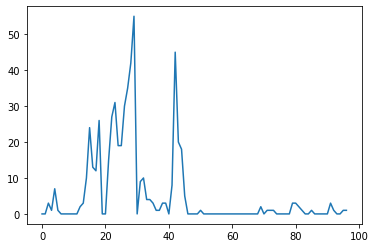

train size: 425 
test size: 106 
classes: 97 
features: 101


In [495]:
train, test, n = getData('kNN/spectrometer.csv')
print("train size:", len(train), "\ntest size:", len(test), "\nclasses:", n,"\nfeatures:",  len(train[0]['vector']))

In [496]:
classifier = lambda v: kNN(v, n, train, 10.0, uniform, distance.cityblock)
f = testAlgo(test, n, classifier)
print(f)

0.006064690026954178


In [497]:
def gridSearch(f, l, r, eps):
    if abs(r - l) < eps:
        return [], l, -1e100
    res = []
    bestX, best = l, -1e100
    for x in [l + i / 10 * (r - l) for i in range(11)]:
        y = f(x)
        res.append({'x': x, 'y' : y})
        if y > best:
            bestX = x
            best = y
    res2, newBestX, newBest = gridSearch(f, max(l, bestX - (r - l) / 10), min(r, bestX + (r - l) / 10), eps)
    if newBest > best:
        best = newBest
        bestX = newBestX
    return res + res2, bestX, best

manhattan logistic h =  0.07368000000000001 f =  0.5865578429104847 



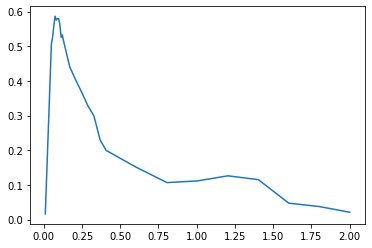

euclidian logistic h =  0.01 f =  0.6272769267017431 



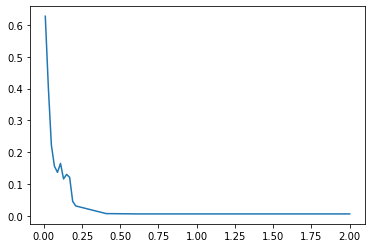

manhattan uniform h =  0.43188 f =  0.4984036784105847 



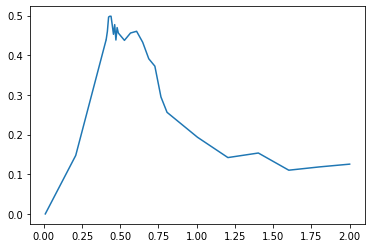

euclidian uniform h =  0.06572 f =  0.49991473369473133 



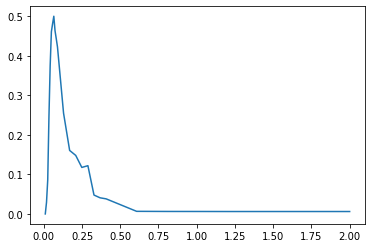

manhattan triangular h =  0.6547599999999999 f =  0.5139654861506696 



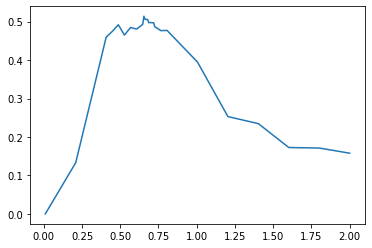

euclidian triangular h =  0.06572000000000001 f =  0.5353927689921366 



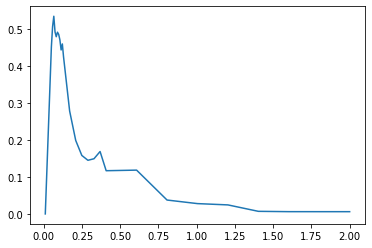

manhattan epanechnikov h =  0.8856 f =  0.5244403837368662 



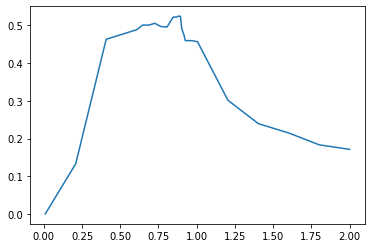

euclidian epanechnikov h =  0.06572000000000001 f =  0.5357145308414037 



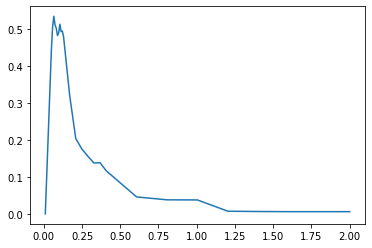

manhattan quartic h =  0.65476 f =  0.5060146831211221 



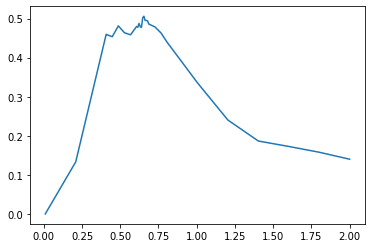

euclidian quartic h =  0.06572000000000001 f =  0.5353927689921366 



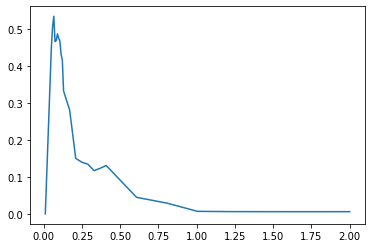

manhattan triweight h =  0.77416 f =  0.5263143788294463 



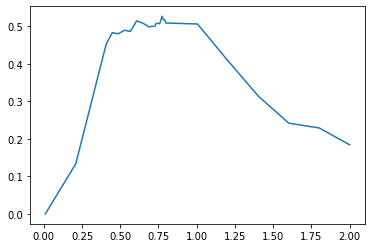

euclidian triweight h =  0.07368000000000001 f =  0.5429327035856916 



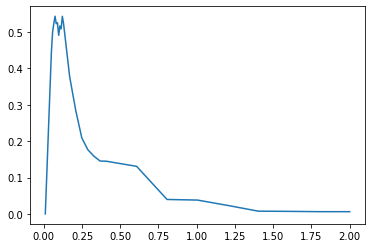

manhattan tricube h =  0.8458000000000001 f =  0.5251459795404029 



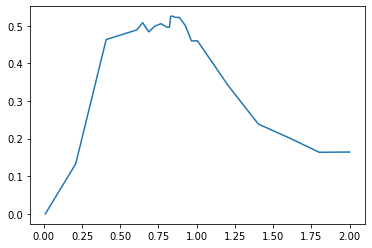

euclidian tricube h =  0.07368000000000001 f =  0.5360102169583264 



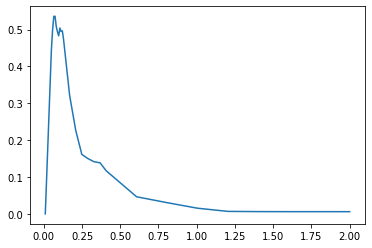

manhattan gaussian h =  0.15328000000000003 f =  0.5795280067928256 



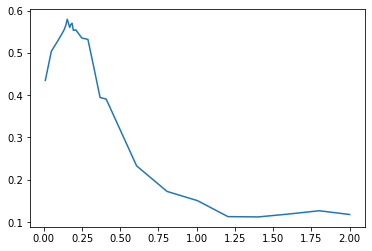

euclidian gaussian h =  0.01 f =  0.5480223894428587 



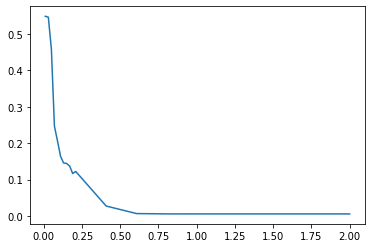

manhattan cosine h =  0.6547599999999999 f =  0.5060146831211221 



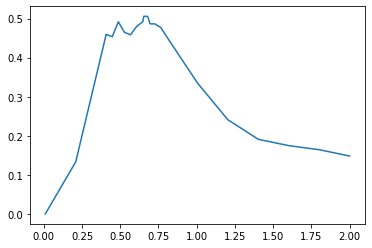

euclidian cosine h =  0.06572000000000001 f =  0.5353927689921366 



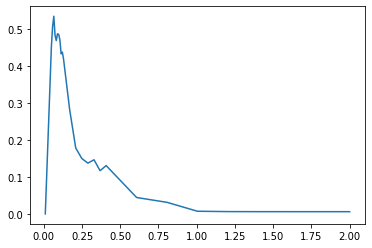

manhattan sigmoid h =  0.07368000000000001 f =  0.5953784712567426 



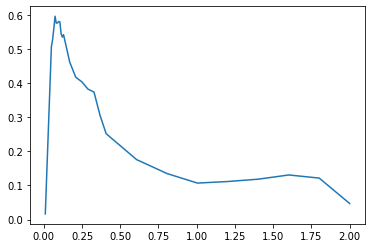

euclidian sigmoid h =  0.01 f =  0.6272769267017431 



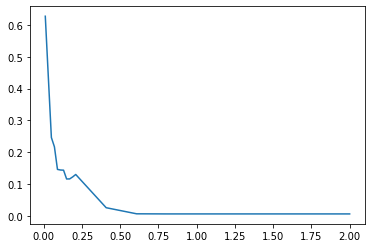

manhattan silverman h =  0.26472 f =  0.5001782696144205 



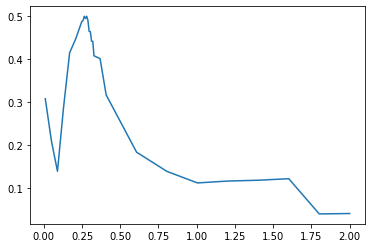

euclidian silverman h =  0.029900000000000003 f =  0.4841566322176923 



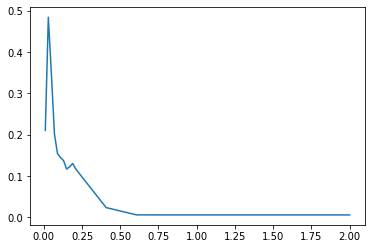

manhattan id h =  0.01 f =  0.006064690026954178 



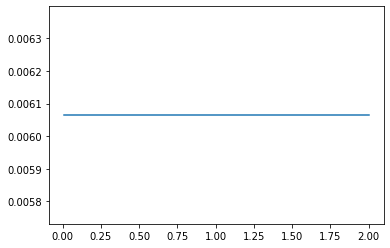

euclidian id h =  0.01 f =  0.006064690026954178 



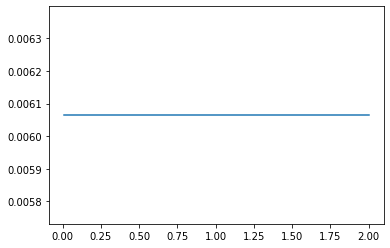

In [498]:
for kernelName in allKernels:
    kernel = allKernels[kernelName]
    for distName in allDistances:
        dist = allDistances[distName]
        
        f = lambda h: testAlgo(test, n, lambda v: kNN(v, n, train, h, kernel, dist))
        res, bestH, f = gridSearch(f, 0.01, 2.0, 0.05)
        
        xs = []
        ys = []
        for obj in sorted(res, key = lambda obj : obj['x']):
            xs.append(obj['x'])
            ys.append(obj['y'])
        
        print(distName, kernelName, "h = ", bestH, "f = ", f,'\n')
        
        pyplot.plot(xs, ys)
        pyplot.show()

manhattan logistic k =  1.0 f =  0.2379271568640928 



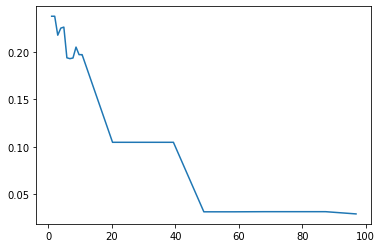

euclidian logistic k =  3.304000000000002 f =  0.20902872679733606 



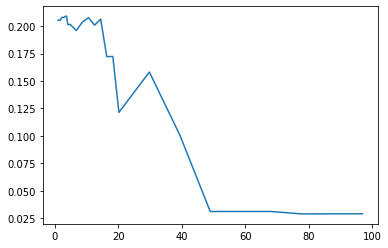

manhattan uniform k =  4.84 f =  0.5378318577535147 



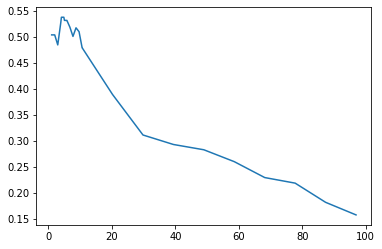

euclidian uniform k =  1.0 f =  0.5855353382295425 



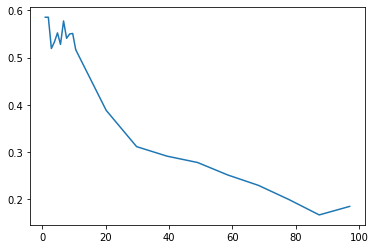

manhattan triangular k =  8.680000000000003 f =  0.5650195103629289 



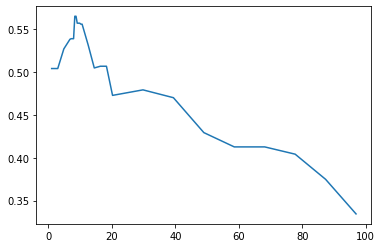

euclidian triangular k =  9.064000000000004 f =  0.6376530341734156 



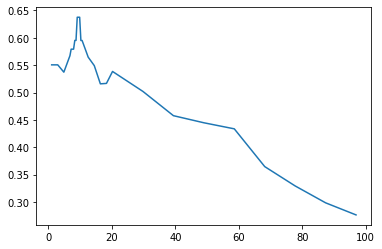

manhattan epanechnikov k =  14.440000000000003 f =  0.5885829787088507 



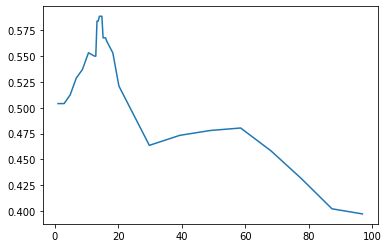

euclidian epanechnikov k =  16.360000000000007 f =  0.6083795040942953 



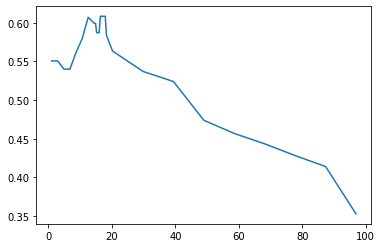

manhattan quartic k =  8.680000000000003 f =  0.5627335191602205 



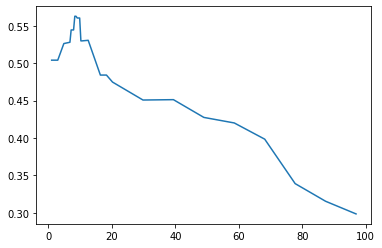

euclidian quartic k =  9.064000000000004 f =  0.6001889404858651 



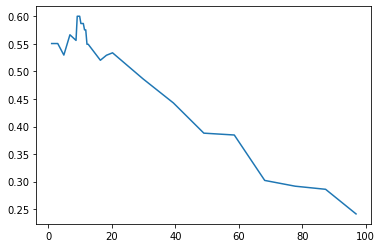

manhattan triweight k =  21.352000000000004 f =  0.5941667454900975 



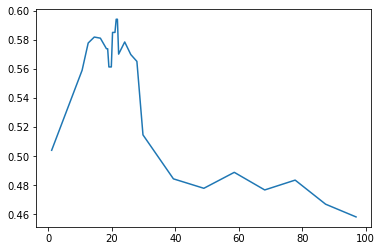

euclidian triweight k =  20.200000000000003 f =  0.6146962079994407 



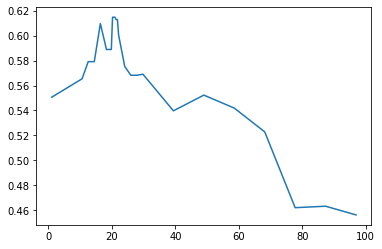

manhattan tricube k =  16.360000000000007 f =  0.5850572383365108 



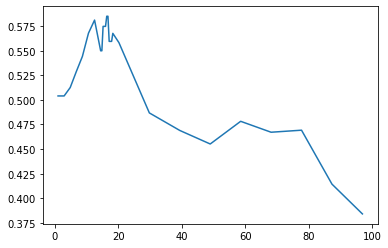

euclidian tricube k =  18.28000000000001 f =  0.6132417622289534 



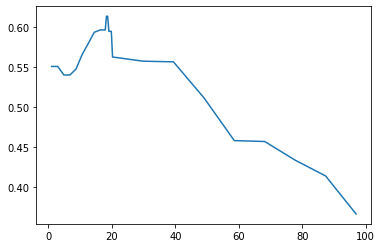

manhattan gaussian k =  1.0 f =  0.40020132930929886 



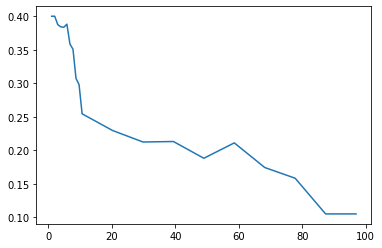

euclidian gaussian k =  1.0 f =  0.39589102752018773 



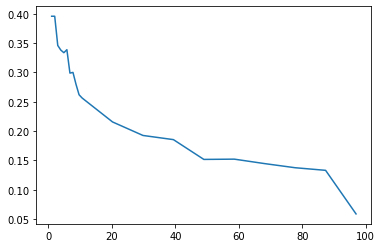

manhattan cosine k =  8.680000000000003 f =  0.5689372274044969 



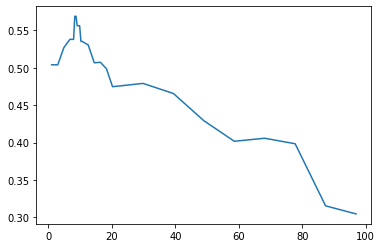

euclidian cosine k =  9.064000000000004 f =  0.6001889404858651 



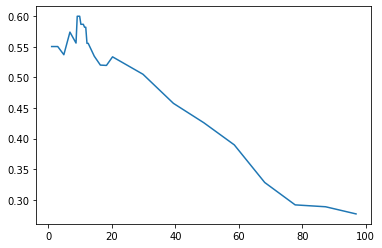

manhattan sigmoid k =  1.0 f =  0.3377800451849387 



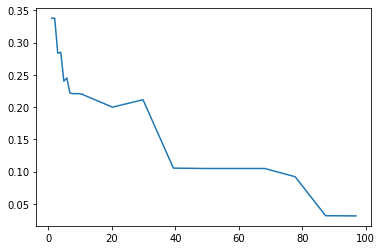

euclidian sigmoid k =  1.0 f =  0.27715828122338204 



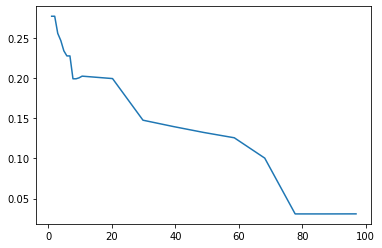

manhattan silverman k =  1.0 f =  0.3628483278313234 



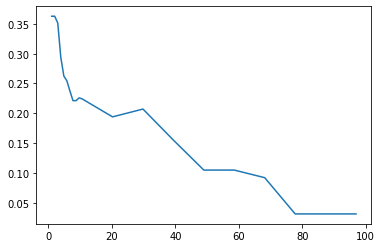

euclidian silverman k =  1.0 f =  0.3365223030784191 



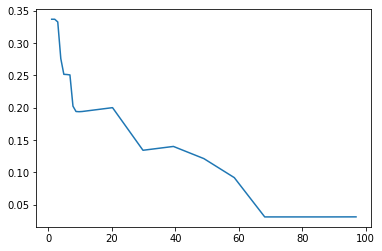

manhattan id k =  1.0 f =  0.006064690026954178 



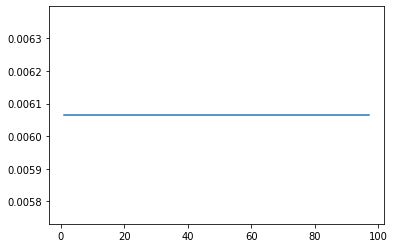

euclidian id k =  1.0 f =  0.006064690026954178 



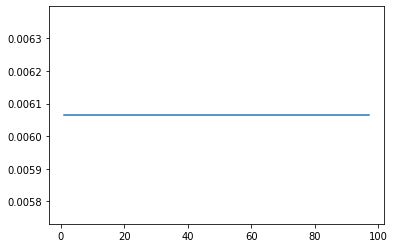

In [499]:
for kernelName in allKernels:
    kernel = allKernels[kernelName]
    for distName in allDistances:
        dist = allDistances[distName]
        
        f = lambda k: testAlgo(test, n, lambda v: varKNN(v, n, train, k, kernel, dist))
        res, bestH, f = gridSearch(f, 1, n, 1)
        
        xs = []
        ys = []
        for obj in sorted(res, key = lambda obj : obj['x']):
            xs.append(obj['x'])
            ys.append(obj['y'])
        
        print(distName, kernelName, "k = ", bestH, "f = ", f,'\n')
        
        pyplot.plot(xs, ys)
        pyplot.show()